We've looked a lot at different dither functions, but mostly at the end of the 10-year survey. It might be a good idea to check the time evolution of the co-added depth power spectrum.  

In [1]:
%matplotlib inline
import numpy as np
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.utils as utils
import healpy as hp
import matplotlib.pylab as plt

In [2]:
opsdb = db.OpsimDatabase('minion_1016_sqlite.db')
propids, propTags = opsdb.fetchPropInfo()
wfdWhere = utils.createSQLWhere('WFD', propTags)
outDir = 'null'
resultsDb = db.ResultsDb(outDir=outDir)

In [3]:
nside = 128


In [4]:
class HexDither_small(stackers.HexDitherFieldVisitStacker):
    """
    Same as HexDitherFieldVisitStacker, but change the order of the offsets (small offsets first, large last)
    """
    def __init__(self, raCol='fieldRA', decCol='fieldDec', fieldIdCol='fieldIdCol', nightCol='night', maxDither=1.8, inHex=True):
        """
        @ MaxDither in degrees
        """
        super(HexDither_small, self).__init__(raCol=raCol, decCol=decCol, maxDither=maxDither, inHex=inHex)
        self.nightCol = nightCol
        # Values required for framework operation: this specifies the names of the new columns.
        self.colsAdded = ['ra_small', 'dec_small']
        # Values required for framework operation: this specifies the data columns required from the database.
        self.colsReq.append(self.nightCol)

    def _generateHexOffsets(self):
        super(HexDither_small, self)._generateHexOffsets()
        # New part to order things differently
        radius_off_sq = self.xOff**2 + self.yOff**2
        newOrder = np.argsort(radius_off_sq)
        print 'Doing small dithers'
        self.xOff = self.xOff[newOrder]
        self.yOff = self.yOff[newOrder]
        
    def _run(self, simData):
        self._generateHexOffsets()
        for fieldid in np.unique(simData[self.fieldIdCol]):
            # Identify observations of this field.
            match = np.where(simData[self.fieldIdCol] == fieldid)[0]
            # Apply a sequential dither, increasing each night.
            vertexIdxs = np.arange(0, len(match), 1)
            nights = simData[self.nightCol][match]
            vertexIdxs = np.searchsorted(np.unique(nights), nights)
            vertexIdxs = vertexIdxs % self.numPoints
            simData['ra_small'][match] = simData[self.raCol][match] + \
              self.xOff[vertexIdxs]/np.cos(simData[self.decCol][match])
            simData['dec_small'][match] = simData[self.decCol][match] + self.yOff[vertexIdxs]
        # Wrap into expected range.
        simData['ra_small'], simData['dec_small'] = \
          stackers.wrapRADec(simData['ra_small'], simData['dec_small'])
        return simData


In [5]:
class HexDither_big(stackers.HexDitherFieldVisitStacker):
    """
    Same as HexDitherFieldVisitStacker, but change the order of the offsets (large offsets first, small last)
    """
    def __init__(self, raCol='fieldRA', decCol='fieldDec', fieldIdCol='fieldIdCol', nightCol='night', maxDither=1.8, inHex=True):
        """
        @ MaxDither in degrees
        """
        super(HexDither_big, self).__init__(raCol=raCol, decCol=decCol, maxDither=maxDither, inHex=inHex)
        self.nightCol = nightCol
        # Values required for framework operation: this specifies the names of the new columns.
        self.colsAdded = ['ra_big', 'dec_big']
        # Values required for framework operation: this specifies the data columns required from the database.
        self.colsReq.append(self.nightCol)

    def _generateHexOffsets(self):
        super(HexDither_big, self)._generateHexOffsets()
        # New part to order things differently
        radius_off_sq = self.xOff**2 + self.yOff**2
        newOrder = np.argsort(radius_off_sq)[::-1]
        print 'Doing big dithers'
        self.xOff = self.xOff[newOrder]
        self.yOff = self.yOff[newOrder]
        
    def _run(self, simData):
        self._generateHexOffsets()
        for fieldid in np.unique(simData[self.fieldIdCol]):
            # Identify observations of this field.
            match = np.where(simData[self.fieldIdCol] == fieldid)[0]
            # Apply a sequential dither, increasing each night.
            vertexIdxs = np.arange(0, len(match), 1)
            nights = simData[self.nightCol][match]
            vertexIdxs = np.searchsorted(np.unique(nights), nights)
            vertexIdxs = vertexIdxs % self.numPoints
            simData['ra_big'][match] = simData[self.raCol][match] + \
              self.xOff[vertexIdxs]/np.cos(simData[self.decCol][match])
            simData['dec_big'][match] = simData[self.decCol][match] + self.yOff[vertexIdxs]
        # Wrap into expected range.
        simData['ra_big'], simData['dec_big'] = \
          stackers.wrapRADec(simData['ra_big'], simData['dec_big'])
        return simData

In [6]:
bundleList = []
plotFuncs = [plots.TwoDMap()]
survey_length = 10.  # Years
sql = 'filter = "r" and night < %f and ' % (365.25*survey_length) + wfdWhere
step_size = 30. # Days
bins = np.arange(0,365.25*survey_length+step_size,step_size)

plotDict = {'xlabel':'Night (days)', 'xextent':[bins.min()+step_size,bins.max()+step_size], 'cbarTitle':'5-sigma depth'}

slicer =  slicers.HealpixSlicer(nside=nside, lonCol='hexDitherFieldNightRa', latCol='hexDitherFieldNightDec')
metric = metrics.AccumulateM5Metric(bins=bins, metricName='M5_defaultsteps')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, plotFuncs=plotFuncs, plotDict=plotDict))

slicer =  slicers.HealpixSlicer(nside=nside, lonCol='ra_small', latCol='dec_small')
metric = metrics.AccumulateM5Metric(bins=bins, metricName='M5_small')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, plotFuncs=plotFuncs, plotDict=plotDict))

#stacker = HexDitherNightStacker_bigOffFirst(reverse=True)
#slicer = slicers.HealpixSlicer(nside=nside, lonCol='randomDitherFieldNightRa', latCol='randomDitherFieldNightDec')
slicer =  slicers.HealpixSlicer(nside=nside, lonCol='ra_big', latCol='dec_big')
metric = metrics.AccumulateM5Metric(bins=bins, metricName='M5_bigsteps1st')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql,  plotFuncs=plotFuncs, plotDict=plotDict))

# Let's do one with no dither so it's easy to grab regions to mask
slicer = slicers.HealpixSlicer(nside=nside, lonCol='fieldRA', latCol='fieldDec')
metric = metrics.AccumulateM5Metric(bins=bins, metricName='m5_nodither')
bundleList.append(metricBundles.MetricBundle(metric, slicer, sql, plotFuncs=plotFuncs, plotDict=plotDict))


Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [7]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)
bg.runAll()

Querying database with constraint filter = "r" and night < 3652.500000 and propID = 54
Found 456557 visits
Running:  ['opsim_M5_small_r_and_night_lt_3652_500000_and_propID_54_HEAL']
Doing small dithers
Completed metric generation.
Running:  ['opsim_m5_nodither_r_and_night_lt_3652_500000_and_propID_54_HEAL']
Completed metric generation.
Running:  ['opsim_M5_bigsteps1st_r_and_night_lt_3652_500000_and_propID_54_HEAL']
Doing big dithers
Completed metric generation.
Running:  ['opsim_M5_defaultsteps_r_and_night_lt_3652_500000_and_propID_54_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with filter = "r" and night < 3652.500000 and propID = 54 sqlconstraint now.
Plotting complete.


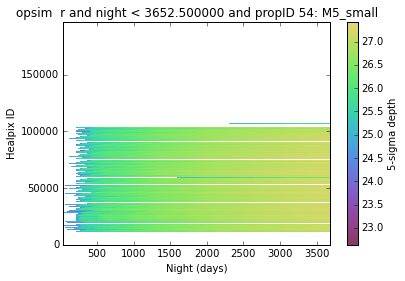

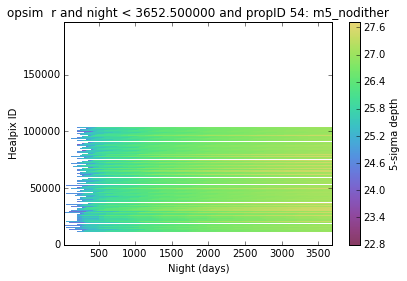

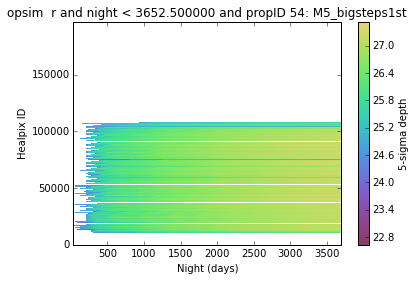

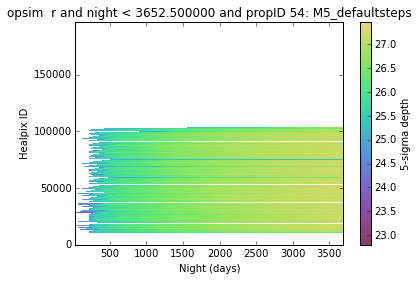

In [8]:
bg.plotAll(closefigs=False)

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


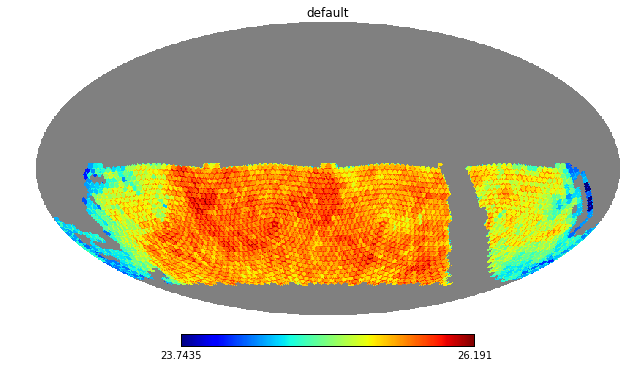

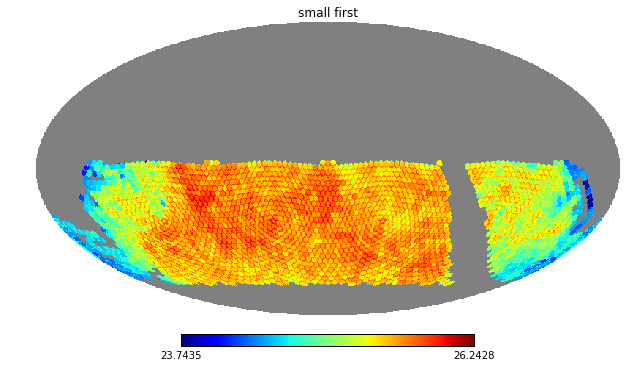

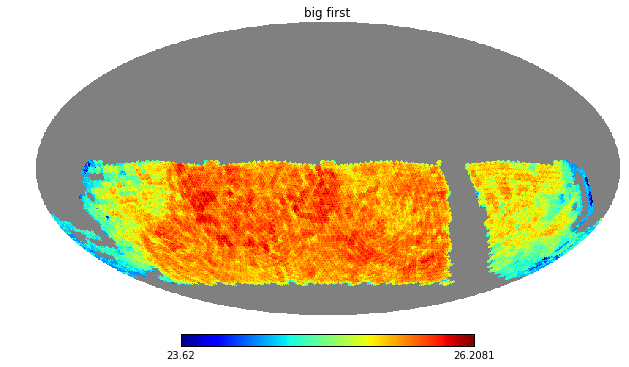

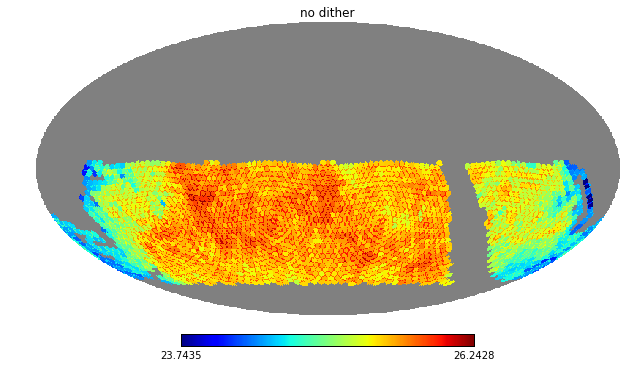

In [9]:
mask = np.where(bundleList[-1].metricValues.mask == True)
for bundle in bundleList:
    bundle.metricValues.mask[mask] = True

magMin = None #26.5
magMax= None #27.5
# Take a look after 200 days
i = 10
hp.mollview(bundleList[0].metricValues[:,i], title='default', min=magMin, max=magMax)
hp.mollview(bundleList[1].metricValues[:,i], title='small first', min=magMin, max=magMax)
hp.mollview(bundleList[2].metricValues[:,i], title='big first', min=magMin, max=magMax)
hp.mollview(bundleList[3].metricValues[:,i], title='no dither', min=magMin, max=magMax)


In [10]:
# ok, now to loop over each bundle and each bin in the metric values and find the peak of the power spectrum.

In [11]:
# List for each bundle
powerList = []
for bundle in bundleList:
    pl = []
    # Loop through different time steps and compute the power spcetrum
    for i, _dummy in enumerate(bins[1:]):
        hpmap = bundle.metricValues[:,i]
        cl = hp.anafast(hp.remove_dipole(hpmap, verbose=False))
        ell = np.arange(np.size(cl))
        pl.append((cl * ell * (ell + 1)) / 2.0 / np.pi)
    powerList.append(np.array(pl))

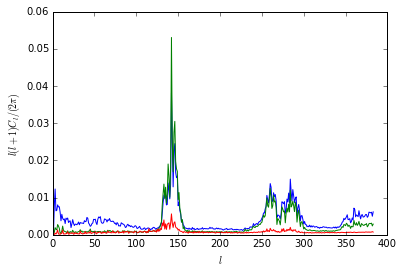

In [12]:
# The small-first dithering
plt.plot(ell, powerList[1][10,:])
plt.plot(ell, powerList[1][20,:])
plt.plot(ell, powerList[1][-1,:])
plt.xlabel(r'$l$')
plt.ylabel(r'$l(l+1)C_l/(2\pi)$')

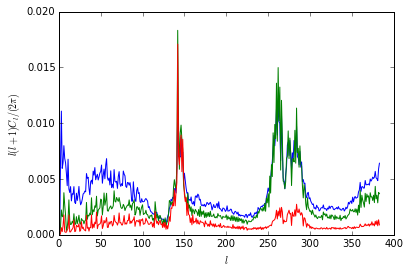

In [13]:
# Doing the big dither steps first.
plt.plot(ell, powerList[2][10,:])
plt.plot(ell, powerList[2][20,:])
plt.plot(ell, powerList[2][-1,:])
plt.xlabel(r'$l$')
plt.ylabel(r'$l(l+1)C_l/(2\pi)$')

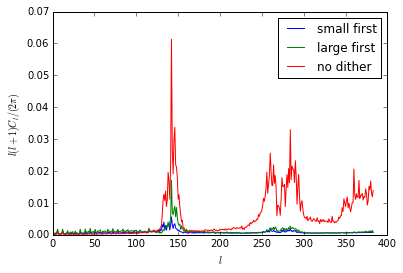

In [14]:
# At the end of the survey
plt.plot(ell, powerList[1][-1,:], label='small first')
plt.plot(ell, powerList[2][-1,:], label = 'large first')
plt.plot(ell, powerList[3][-1,:], label='no dither')
plt.legend()
plt.xlabel(r'$l$')
plt.ylabel(r'$l(l+1)C_l/(2\pi)$')

I think that makes it pretty clear that we also have the ability to fiddle with how fast the power spectrum flattens out during the survey.  Or, at least we can pick which peak to squash first if we want to. Anyway, I think someone should make the point that it should be possible in the first year of observations to reduce power at cosmologically interesting scales (and close the photometric system).  

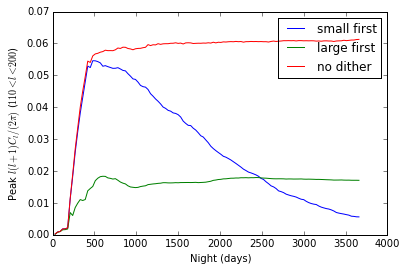

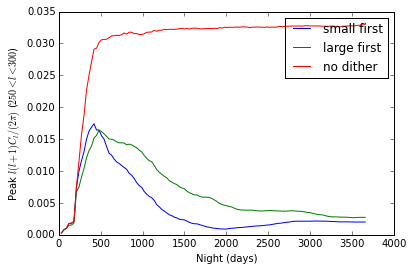

In [20]:
# Let's look at the time evolution of the peaks

ell_150 = np.where((ell > 110) & (ell < 200))[0]
ell_250 = np.where((ell > 250) & (ell < 300))[0] 
plt.figure()
toplot = {1:'small first', 2:'large first', 3:'no dither'}
for i in toplot:
    plt.plot(bins[1:], np.max(powerList[i][:,ell_150], axis=1), label=toplot[i])
plt.xlabel('Night (days)')
plt.ylabel('Peak $l(l+1)C_l/(2\pi)$ ($110 < l < 200$)')
plt.legend()

plt.figure()
for i in toplot:
    plt.plot(bins[1:], np.max(powerList[i][:,ell_250], axis=1), label=toplot[i])
plt.xlabel('Night (days)')
plt.ylabel('Peak $l(l+1)C_l/(2\pi)$ ($250 < l < 300$)')
plt.legend()
